# MediaPipe

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns

import mediapipe_holistic as mh

In [ ]:
# change working directory to the project root directory
current_dir = os.getcwd()
os.chdir(current_dir + '/../../')
# this should be the project root directory
os.getcwd()

'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage'

## Information

### MediaPipe Holistic 
#### [DOCS](https://github.com/google-ai-edge/mediapipe/blob/master/docs/solutions/holistic.md)

MediaPipe Holistic utilizes the pose, face and hand landmark models in [MediaPipe Pose](https://github.com/google-ai-edge/mediapipe/blob/master/docs/solutions/pose.md), [MediaPipe Face Mesh](https://github.com/google-ai-edge/mediapipe/blob/master/docs/solutions/face_mesh.md) and [MediaPipe Hands](https://github.com/google-ai-edge/mediapipe/blob/master/docs/solutions/hands.md) respectively to generate a total of 543 landmarks (33 pose landmarks, 468 face landmarks, and 21 hand landmarks per hand).

**INPUT**

480x480

**Output**

Naming style may differ slightly across platforms/languages.

**pose_landmarks**

A list of pose landmarks. Each landmark consists of the following:

- `x` and `y`: Landmark coordinates normalized to `[0.0, 1.0]` by the image width and height respectively.
- `z`: Should be discarded as currently the model is not fully trained to predict depth, but this is something on the roadmap.
- `visibility`: A value in `[0.0, 1.0]` indicating the likelihood of the landmark being visible (present and not occluded) in the image.

**pose_world_landmarks**

Another list of pose landmarks in world coordinates. Each landmark consists of the following:

- `x`, `y` and `z`: Real-world 3D coordinates in meters with the origin at the center between hips.
- `visibility`: Identical to that defined in the corresponding [pose_landmarks](https://github.com/google-ai-edge/mediapipe/blob/master/docs/solutions/holistic.md#pose_landmarks).

**face_landmarks**

A list of 468 face landmarks. Each landmark consists of `x`, `y` and `z`. `x` and `y` are normalized to `[0.0, 1.0]` by the image width and height respectively. `z` represents the landmark depth with the depth at center of the head being the origin, and the smaller the value the closer the landmark is to the camera. The magnitude of `z` uses roughly the same scale as `x`.

**left_hand_landmarks**

A list of 21 hand landmarks on the left hand. Each landmark consists of `x`, `y` and `z`. `x` and `y` are normalized to `[0.0, 1.0]` by the image width and height respectively. `z` represents the landmark depth with the depth at the wrist being the origin, and the smaller the value the closer the landmark is to the camera. The magnitude of `z` uses roughly the same scale as `x`.

**right_hand_landmarks**

A list of 21 hand landmarks on the right hand, in the same representation as [left_hand_landmarks](https://github.com/google-ai-edge/mediapipe/blob/master/docs/solutions/holistic.md#left_hand_landmarks).

**segmentation_mask**

The output segmentation mask, predicted only when [enable_segmentation](https://github.com/google-ai-edge/mediapipe/blob/master/docs/solutions/holistic.md#enable_segmentation) is set to `true`. The mask has the same width and height as the input image, and contains values in `[0.0, 1.0]` where `1.0` and `0.0` indicate high certainty of a "human" and "background" pixel respectively. Please refer to the platform-specific usage examples below for usage details.

## Load Video Metadata

In [4]:
video_metadata_df = pd.read_csv('data/raw/combined/target_dataset_video_metadata(sample).csv')

## Holistic Model

In [5]:
i = 1
row = video_metadata_df.iloc[i]
video_path = f"data/raw/combined/videos/{row.filename}"
video_path

'data/raw/combined/videos/ABACAXI_sb_2.mp4'

In [6]:
# Initialize detector
detector = mh.MediaPipeHolisticDetector(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    model_complexity=1,  # 0=Lite, 1=Full, 2=Heavy
    refine_face_landmarks=True
)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1742917682.270894  171755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742917682.315030  171755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742917682.321885  171757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742917682.327231  171755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742917682.327840  171756 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742917682.369453  171

In [7]:
# Process video
results = detector.process_video(video_path, output_path=f"holistic.mp4")

W0000 00:00:1742917685.203190  171754 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


In [8]:
def get_frame(frame_index, video_path):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)  # Set frame index
    ret, frame = cap.read()
    cap.release()
    if not ret:
        print(f"Could not read frame {frame_index} from video")
        frame = None
    return frame

frame_index = 10
frame = get_frame(frame_index, video_path)

In [9]:
frame_viz, blank_viz = detector.visualize_frame_with_blank(frame, results[frame_index])

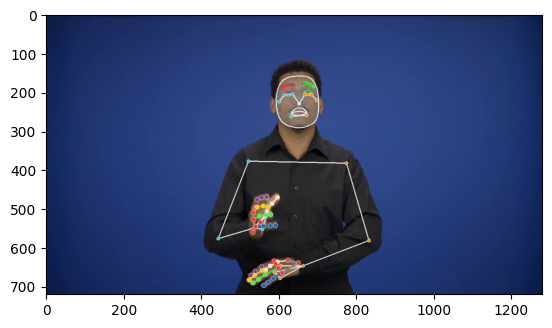

In [10]:
plt.imshow(frame_viz[:,:,[2,1,0]])

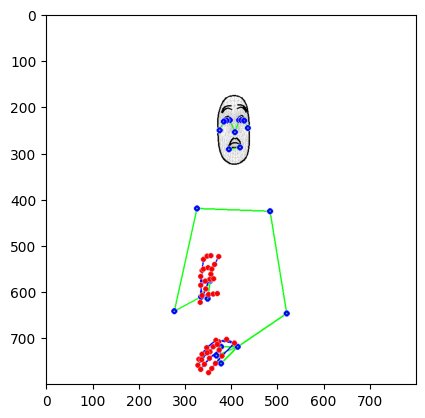

In [11]:
plt.imshow(blank_viz[:,:,[2,1,0]])

In [12]:
# Option 3: Get just the blank canvas visualization
blank_canvas = detector.draw_landmarks_on_blank(
    results[frame_index],
    canvas_size=1000,  # Custom size
    background_color=(0, 0, 0)  # Black background
)

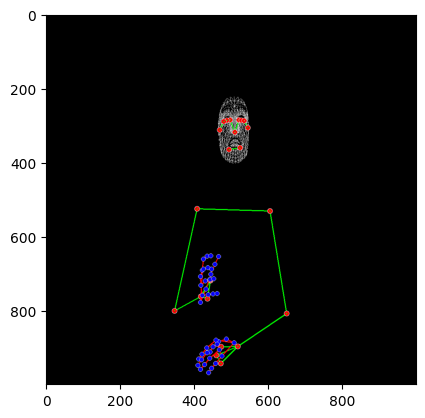

In [13]:
plt.imshow(blank_canvas)

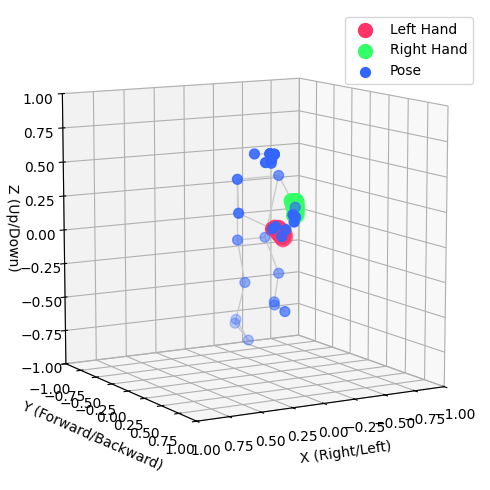

In [14]:
fig = detector.draw_landmarks_3d(
    results[frame_index],  # landmarks from first frame
    figsize=(5, 5),
    elev=10,     # Look slightly from above
    azim=60,     # 45-degree horizontal rotation
    xlim=(-1, 1),
    ylim=(-1, 1),
    zlim=(-1, 1)
)

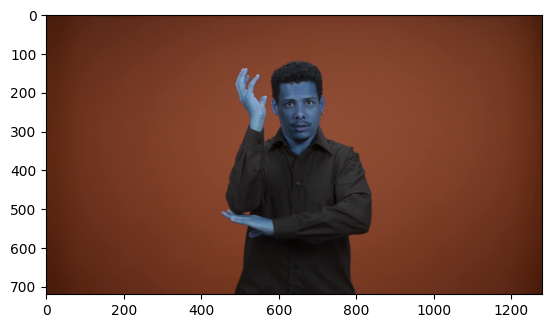

In [15]:
plt.imshow(get_frame(50, video_path))

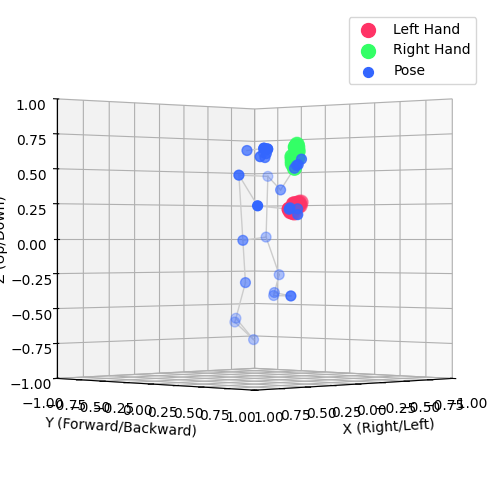

In [17]:
fig = detector.draw_landmarks_3d(
    results[50],  # landmarks from first frame
    figsize=(5, 5),
    elev=0,     # Look slightly from above
    azim=45,     # 45-degree horizontal rotation
    xlim=(-1, 1),
    ylim=(-1, 1),
    zlim=(-1, 1)
)